In [1]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_ext.models.openai import OpenAIChatCompletionClient 
import dotenv
import requests
from bs4 import BeautifulSoup
import datetime

In [2]:
oai_api_key = dotenv.get_key('.env.local', 'OPENAI_API_KEY')

In [3]:
async def get_abasin_info() -> str:
    f"""Get raw conditions data from Arapahoe Basin's website."""
    response = requests.get('https://www.arapahoebasin.com/snow-report/')
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        condition_divs = soup.find_all('div', class_=['conditions', 'weather'])
        return condition_divs
    return []

In [4]:
#from scrape_caic import get_avalanche_info
import json
import base64
from IPython.display import Image, display
def get_avalanche_info(lat: float, long: float) -> str:
    """
    Run a separate Python script using sync Playwright to capture avalanche info.
    
    Args:
        lat (float): Latitude
        long (float): Longitude
    Returns:
        str: A base64-encoded screenshot (or a file path) showing avalanche conditions.
    """
    # 1) Run the external script. This returns a list of stdout lines.
    output_lines = !python scrape_caic.py {lat} {long}
    if not output_lines:
        return "No output from scrape_caic.py"

    try:
        data = json.loads(output_lines[-1])
        b64_str = data["image_base64"]

        img_path = "images/avalanche_inline.png"
        with open(img_path, "wb") as f:
            f.write(base64.b64decode(b64_str))
        display(Image(filename=img_path))
        
        return b64_str
    except Exception as e:
        return f"JSON parsing error: {e}"


async def main() -> None:
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    abasin_agent = AssistantAgent(
        name="abasin_agent",
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o",
            api_key=oai_api_key,
        ),
        tools=[get_abasin_info, get_avalanche_info],
        system_message=f"""Return a short conditions assessment followed by a markdown 
        summary of A Basin's conditions. If you need avalanche conditions, call the get_avalanche_conditions 
        tool and pass it two variables, the lat 39.6427 and long 105.8718. Let the other agents 
        know this is all the information you can access at this time. The current date is {current_date}.""",
    )

    ski_agent = AssistantAgent(
        "primary",
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o",
            api_key=oai_api_key,
        ),
        tools=[],
        system_message=f"""Describe why or why the user should not go skiing at a given time. You can chat with
        another AI agent by calling a tool to get weather and conditions. The current date is {current_date}. 
        
        Anything you say is just your internal thoughts and conversation with the other AI agents. When you have 
        made your decision, you can send a message to the user by including 'TERMINATE' as the final output.""",
    )

    # max_msg_termination = MaxMessageTermination(max_messages=3)
    termination = TextMentionTermination("TERMINATE")
    agent_team = RoundRobinGroupChat([ski_agent, abasin_agent], termination_condition=(termination))

    stream = agent_team.run_stream(task="Should I ski at A Basin tomorrow or hit the backcountry nearby?")
    await Console(stream)

---------- user ----------
Should I ski at A Basin tomorrow or hit the backcountry nearby?
---------- primary ----------
I should first check the latest weather and conditions for A Basin and the nearby backcountry to make an informed decision. Let me call the weather and conditions tool to gather this information.
[Prompt tokens: 119, Completion tokens: 37]
---------- abasin_agent ----------
[FunctionCall(id='call_XselDM0HvvMExS6OLQf4fVMJ', arguments='{}', name='get_abasin_info'), FunctionCall(id='call_MAKweEJdX6bAhDmbnCAVtf76', arguments='{"lat": 39.6427, "long": -105.8718}', name='get_avalanche_info')]
[Prompt tokens: 258, Completion tokens: 58]


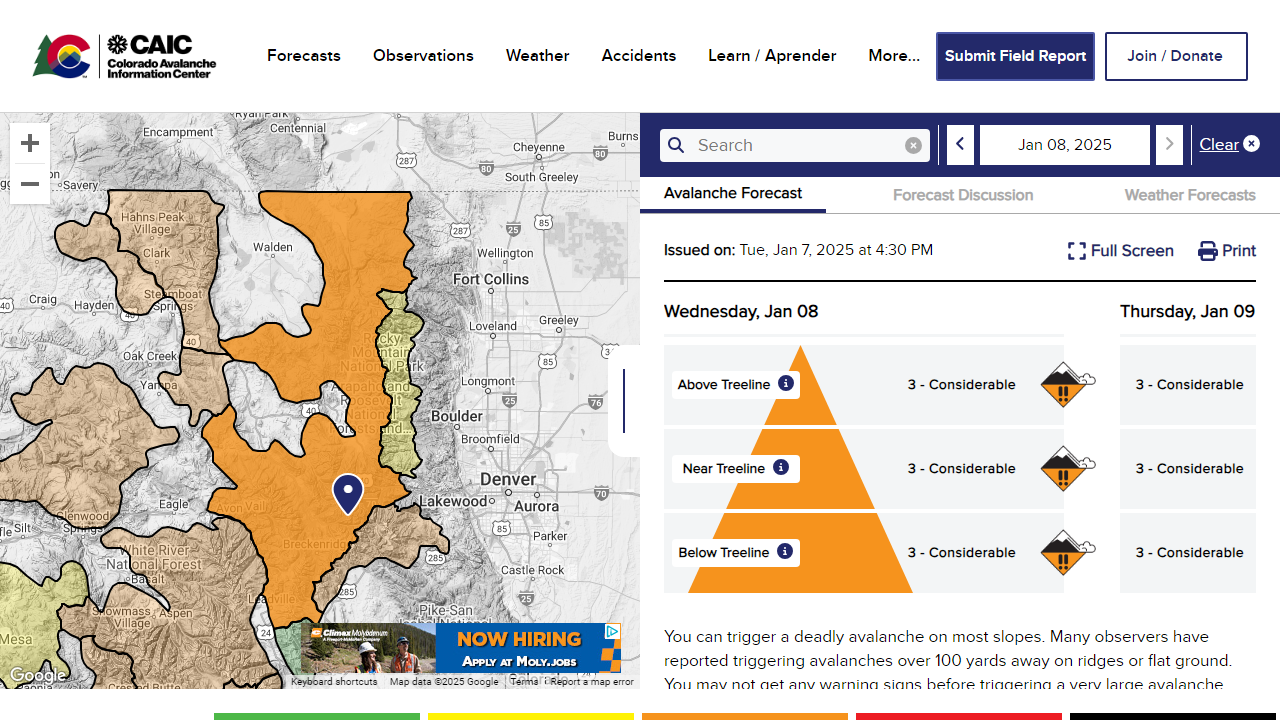

---------- abasin_agent ----------
[FunctionExecutionResult(content='[<div class="conditions">\n<svg fill="none" height="20" viewbox="0 0 19 20" width="19" xmlns="http://www.w3.org/2000/svg">\n<rect height="17" opacity="0.7" rx="8.5" stroke="#49AAF0" stroke-width="2" width="17" x="1" y="1.44141"></rect>\n<rect fill="#49AAF0" height="11" rx="5.5" transform="matrix(-1 0 0 1 15 4.44141)" width="11">\n</rect>\n</svg>\n</div>, <div class="conditions">\n<ul>\n<li>\r\n                                                0" <span>Past 24HRS</span>\n</li>\n<li>\r\n                                                3" <span>Past 48HRS</span>\n</li>\n<li>\r\n                                                46" <span>Base</span>\n</li>\n</ul>\n<a class="close-widget primary ab-mt-32" href="/snow-report/#snowReport">SEE SNOW REPORT</a>\n</div>, <div class="conditions">\n<ul>\n<li>\r\n                                            11° <span class="temp">f</span> <span>Todays High</span>\n</li>\n<li>\r\n        

Error processing publish message
Traceback (most recent call last):
  File "c:\wdgit\ai-experiments\autogen\ski-buddy\.venv\Lib\site-packages\autogen_core\_single_threaded_agent_runtime.py", line 397, in _process_publish
    await asyncio.gather(*responses)
  File "c:\wdgit\ai-experiments\autogen\ski-buddy\.venv\Lib\site-packages\autogen_core\_single_threaded_agent_runtime.py", line 389, in _on_message
    return await agent.on_message(
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\wdgit\ai-experiments\autogen\ski-buddy\.venv\Lib\site-packages\autogen_core\_base_agent.py", line 113, in on_message
    return await self.on_message_impl(message, ctx)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\wdgit\ai-experiments\autogen\ski-buddy\.venv\Lib\site-packages\autogen_agentchat\teams\_group_chat\_sequential_routed_agent.py", line 48, in on_message_impl
    return await super().on_message_impl(message, ctx)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\wdg

---------- Summary ----------
Number of messages: 5
Finish reason: None
Total prompt tokens: 377
Total completion tokens: 95
Duration: 11.08 seconds


In [5]:
await main()